In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk import Tree, ne_chunk, pos_tag, word_tokenize

from gensim.models import Word2Vec

import pyLDAvis.sklearn

pd.set_option('display.max_colwidth', 300)

/anaconda3/envs/work_3.7/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
df = pd.read_csv('data/my-the-star-all.csv', sep='|', encoding="utf-8")
df = df.drop(columns=['Unnamed: 0'])

df2 = pd.read_csv('data/cna-news-all.csv', sep='|', encoding="utf-8")
df2 = df2.drop(columns=['Unnamed: 0'])

In [3]:
df2['Category'].value_counts()

asia          324
business      314
world         293
singapore     292
technology    221
health        197
Name: Category, dtype: int64

In [4]:
def nltk2wn_tag(nltk_tag): 
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else: 
        return None

def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    
    lemm_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            lemm_words.append(word)
        else: 
            lemm_words.append(lemmatizer.lemmatize(word, tag))
    
    return " ".join(lemm_words)

In [5]:
# %%time

df['Article'] = df['Article'].apply(lambda a: a.replace('\n',' ')) # .replace("\\'s",'').replace("'",''))

# df['POS_tag'] = df['Article'].apply(lambda a: nltk.pos_tag(nltk.word_tokenize(a)))
# df['Article_lemm'] = df['Article'].apply(lambda a: lemmatize_sentence(a))

# df['article_len'] = df['Article'].apply(lambda a: len(a.split(' ')))


df2['Article'] = df2['Article'].apply(lambda a: a.replace('\\n',' ')) # .replace("\\'s",'').replace("'",''))

# df.drop_duplicates(['PageLink'], inplace=True)#.reset_index()
# df.reset_index(inplace=True, drop=True)

In [21]:
print(df2.shape)

df.head(3)

(1641, 6)


,Title,PageLink,Article,ArticleDate,KeywordSearch,article_len
0,Chinese firms' missing US$6bil tests regulators' resolve - Business News,https://www.thestar.com.my/business/business-news/2019/05/20/chinese-firms-missing-$6-billion-tests-regulators-resolve/,Content Partner Our Radio Stations Video On Demand Copyright © 1995- Star Media Group Berhad (ROC 10894D) Best viewed on Chrome browsers.,"Monday, 20 May 2019",fraud,18
1,Melaka Sentral Terminal to be busy on Raya - Nation,https://www.thestar.com.my/news/nation/2019/05/19/melaka-sentral-terminal-to-be-busy-on-raya/,"MELAKA: The number of people using the Melaka Sentral Terminal here is expected to double to 20,000 a day during the Hari Raya Aidilfitri celebration compared to 10,000 on weekdays. Melaka Chief Minister Adly Zahari said the Central Ticketing System (CTS), which began operating on March 1, would...","Sunday, 19 May 2019",fraud,359
2,‘Stop bid to destroy Duterte’ - Asean+,https://www.thestar.com.my/news/regional/2019/04/23/stop-bid-to-destroy-duterte/,"Manila: The Philippine government has warned the press against plotting to “destroy” President Rodrigo Duterte’s government, as his spokesman accused journalists of spreading fake news. The warning yesterday followed recent local news reports alleging the Duterte family’s involvement in illegal ...","Tuesday, 23 Apr 2019",fraud,446


In [7]:
sent = (df['Article'][69])


In [8]:
sent2 = lemmatize_sentence(sent)
sent2

'Jakarta : Indonesian police say that they have arrest dozen of Islamic-State link terror suspect , include some who plan to detonate bomb at political demonstration when election result be announce next week . Some 29 suspect be round up this month alone , with 60 in all detain since the start of the year in raid across the South-East Asian nation , they say . Eight other suspect have be kill in confrontation with authority , police say , include the wife of a militant who blow up herself and a child follow a dramatic standoff at their home in March . Some arrested suspect be skilled bomb maker and have fight alongside the militant group in Syria , as well as member of local extremist network Jemaah Anshurat Daulah ( JAD ) , police say . JAD have pledge allegiance to IS and be blame for a wave of suicide bombing at church in Indonesia ’ s second-biggest city Surabaya last year . The world ’ s big Muslim majority nation have see a string of attack by militant since the 2002 Bali bombin

## ner

In [21]:
# nltk ner
# import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/s8-jermyn/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
pos_l = nltk.pos_tag(nltk.word_tokenize(sent))
# pos_l = nltk.pos_tag(nltk.word_tokenize(sent), tagset='universal')

(pos_l[0:10])

[('Jakarta', 'NN'),
 (':', ':'),
 ('Indonesian', 'JJ'),
 ('police', 'NN'),
 ('said', 'VBD'),
 ('that', 'IN'),
 ('they', 'PRP'),
 ('have', 'VBP'),
 ('arrested', 'VBN'),
 ('dozens', 'NNS')]

In [10]:
tag_fd = nltk.FreqDist(tag for (word, tag) in pos_l)
word_fd = nltk.FreqDist(word for (word, tag) in pos_l)

# tag_fd.most_common()
word_fd.most_common(n=20)

[(',', 16),
 ('the', 15),
 ('.', 14),
 ('of', 12),
 ('to', 11),
 ('in', 9),
 ('a', 9),
 ('police', 5),
 ('said', 5),
 ('suspects', 5),
 ('has', 5),
 ('they', 4),
 ('including', 4),
 ('at', 4),
 ('and', 4),
 ('as', 4),
 ('’', 4),
 ('on', 4),
 ('who', 3),
 ('demonstrations', 3)]

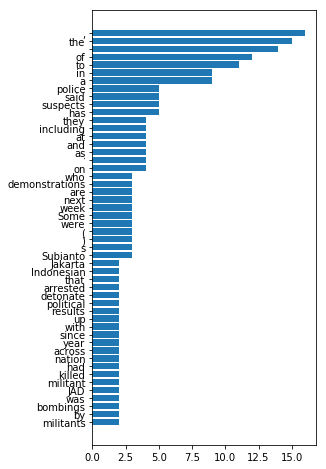

In [11]:
x, y = zip(*word_fd.most_common(n=50))

fig, ax = plt.subplots(figsize=(4,8))
plt.barh(range(len(x)), y)
plt.yticks(range(len(x)), x)
ax.invert_yaxis()
# ax.figure(figsize=(8,6))

plt.show()

In [12]:
# capture only nouns, verbs, proper nouns, and adjectives

p = ['NN', 'VB', 'NNP', 'NNPS', 'JJ']
set([w for w, tag in pos_l if tag in p])

{'1995-',
 'AFP',
 'Anshurat',
 'April',
 'Asian',
 'Bali',
 'Berhad',
 'Chrome',
 'Commission',
 'Content',
 'Copyright',
 'Daulah',
 'Demand',
 'Eight',
 'Elections',
 'General',
 'Group',
 'IS',
 'Indonesia',
 'Indonesian',
 'Iqbal',
 'Islamic-State',
 'JAD',
 'Jakarta',
 'Jemaah',
 'Joko',
 'March',
 'May',
 'Media',
 'Muhammad',
 'Muslim',
 'National',
 'Partner',
 'Police',
 'Prabowo',
 'ROC',
 'Radio',
 'South-East',
 'Star',
 'Stations',
 'Subianto',
 'Surabaya',
 'Syria',
 'Video',
 'WiFi',
 'Widodo',
 'advantage',
 'allegiance',
 'announcement',
 'arrested',
 'attack',
 'be',
 'bomb',
 'bomb-filled',
 'capital',
 'challenger',
 'chaos',
 'child',
 'city',
 'crowded',
 'crowds',
 'dangerous',
 'detonate',
 'dramatic',
 'election',
 'electoral',
 'erupt',
 'extremist',
 'fan',
 'fraud',
 'front',
 'general',
 'go',
 'group',
 'hand',
 'herself',
 'home',
 'last',
 'lead',
 'local',
 'majority',
 'massive',
 'militant',
 'military',
 'month',
 'nation',
 'network',
 'next',
 'of

In [18]:
text = nltk.Text(nltk.word_tokenize(sent))

text.similar('glasses', 5)

spectacles


In [19]:
text.concordance('glasses')

Displaying 6 of 6 matches:
ding a perfect fit when it comes to glasses can be like looking for a needle in
nce . This doyen of made-to-measure glasses was founded in 1879 in Morez in the
ally from Brazil , started crafting glasses while working for his father . He w
ster in the art of crafting bespoke glasses . Maison Bourgeat has been producin
n idea , a photo , a pair of broken glasses , or something that doesn ’ t exist
the final adjustments for a pair of glasses . A single pair of bespoke spectacl


In [22]:
sent = df['Article'][50]

sent

'CARACAS (Reuters) - Venezuelan opposition leader Juan Guaido on Sunday played down the prospects for success at a new round of mediation with the government to be hosted by Norway next week, saying protests would continue until President Nicolas Maduro resigned. Norway said on Saturday that representatives of Venezuela\'s government and opposition will return to Oslo next week following an initial round of preliminary talks about how to address a long-running political crisis. Norway has a tradition of conflict mediation, including assistance with Colombia\'s 2016 peace deal between the government and leftist FARC rebels. "This is not negotiation. This is not dialogue," Guaido told reporters after a rally in the western Venezuelan city of Barquisimeto, adding that his team was simply responding to an offer from the Norwegian government to mediate. Guaido reiterated that any solution to Venezuela\'s crisis required Maduro to stand down, allowing a transitional government to steer the O

In [168]:
pos_l = nltk.pos_tag(nltk.word_tokenize(sent))

entities = nltk.ne_chunk(pos_l, binary=False)
# print(entities)

(S
  (GPE CARACAS/NNP)
  (/(
  (ORGANIZATION Reuters/NNP)
  )/)
  -/:
  (GPE Venezuelan/JJ)
  opposition/NN
  leader/NN
  (PERSON Juan/NNP Guaido/NNP)
  on/IN
  Sunday/NNP
  played/VBD
  down/RP
  the/DT
  prospects/NNS
  for/IN
  success/NN
  at/IN
  a/DT
  new/JJ
  round/NN
  of/IN
  mediation/NN
  with/IN
  the/DT
  government/NN
  to/TO
  be/VB
  hosted/VBN
  by/IN
  (GPE Norway/NNP)
  next/JJ
  week/NN
  ,/,
  saying/VBG
  protests/NNS
  would/MD
  continue/VB
  until/IN
  President/NNP
  (PERSON Nicolas/NNP Maduro/NNP)
  resigned/VBD
  ./.
  (PERSON Norway/NNP)
  said/VBD
  on/IN
  Saturday/NNP
  that/IN
  representatives/NNS
  of/IN
  (GPE Venezuela/NNP)
  's/POS
  government/NN
  and/CC
  opposition/NN
  will/MD
  return/VB
  to/TO
  (GPE Oslo/NNP)
  next/JJ
  week/NN
  following/VBG
  an/DT
  initial/JJ
  round/NN
  of/IN
  preliminary/JJ
  talks/NNS
  about/IN
  how/WRB
  to/TO
  address/VB
  a/DT
  long-running/JJ
  political/JJ
  crisis/NN
  ./.
  (GPE Norway/NNP)
  has/VBZ

## *relationship extraction*

In [13]:
def get_continuous_chunks(text, label):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == label:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

In [16]:
# ORGANIZATION, PERSON, LOCATION, DATE, TIME, MONEY, PERCENT, FACILITY, GPE

get_continuous_chunks(sent, 'PERSON')

['Juan Guaido',
 'Nicolas Maduro',
 'Norway',
 'Guaido',
 'Guaido Venezuela',
 'Maduro',
 'Guaido Venezuela Guaido',
 'Maduro Guaido',
 'Venezuela',
 'Maduro Guaido Venezuela',
 'Maduro Stalin Gonzalez',
 'Guaido Jorge Rodriguez',
 'Hector Rodriguez',
 'Gonzalez',
 'Guaido Twitter',
 'Maduro Deisy Buitrago',
 'Daniel Flynn',
 'Susan Thomas',
 'Stations Video']

In [25]:
# RS extraction
#nltk.sem.extract_rels

articles = df[0:50]

# roles = r'.*\bthe\b(?!\b.+ing)'  
# roles = """.*(commander|of|the|at|in|to|chief|officer).*"""  # "X, of(the) Y"      r'.*\bin\b(?!\b.+ing)'
roles = """.*(command|chief|officer|director|manager|partner|president|producer|head|work|chair|commissioner|executive).*
|to|the|at|in|of"""  # "X, of(the) Y"

ROLES = re.compile(roles, re.VERBOSE)

for i in range(len(articles)):
    pos_l = pos_tag(word_tokenize(articles['Article'][i])) 
    entities = ne_chunk(pos_l, binary=False)
    
    print(i, articles['KeywordSearch'][i])
    for rel in nltk.sem.extract_rels('PER', 'ORG', entities, pattern=ROLES): 
        print(re.sub(r"/[A-Z]*", '', (nltk.sem.rtuple(rel))))
        
#     print(i)
#     for rel in nltk.sem.extract_rels('ORG', 'PER', entities, pattern=ROLES): 
#         print(nltk.sem.rtuple(rel))

0 fraud
1 fraud
2 fraud
3 fraud
4 fraud
5 fraud
6 fraud
7 fraud
8 fraud
9 fraud
[PER: 'Ng Chuey Peng'] ',, managing director and head of global commodities finance at' [ORG: 'Singapore']
[PER: 'Collins'] ',, who was formerly head of metals at' [ORG: 'Trafigura Group']
[PER: 'Ng'] 'was an executive director at' [ORG: 'ABN']
10 fraud
11 fraud
[PER: 'John Teja'] ',, a director at' [ORG: 'Ciptadana Sekuritas']
[PER: 'Harry Su'] ',, managing director and head of equity capital markets at' [ORG: 'Samuel International']
12 fraud
13 fraud
[PER: 'Lena Dunham'] 'are separately working on adapting the' [ORG: 'Anna Delvey']
14 fraud
[PER: 'Antonio Tajani'] ',, president of the' [ORG: 'European Parliament']
15 fraud
16 fraud
17 fraud
18 fraud
19 fraud
20 fraud
21 fraud
[PER: 'Rajesh Upadhyay'] ',, editor-in-chief of' [ORG: 'Vishvas News']
22 fraud
23 fraud
24 fraud
25 fraud
26 fraud
27 fraud
[PER: 'Prabowo'] ',, then commander of the' [ORG: 'Army Strategic Reserve Command']
28 fraud
29 fraud
30 fra

## *topic modelling - LDA*

In [30]:
# %%time

NUM_TOPICS = 2 # test if 2 topics makes sense
TEXTS = df['Article_lemm']

CV = CountVectorizer(min_df=10, max_df=0.85, stop_words='english', lowercase=True) # token_pattern='[a-zA-Z\][a-zA-Z\]{2,}')

TFidf = TfidfVectorizer(min_df=10, max_df=0.85, stop_words='english', lowercase=True) # token_pattern='[a-zA-Z\][a-zA-Z\]{2,}')

vectorized = CV.fit_transform(TEXTS)
# vectorized = TFidf.fit_transform(TEXTS)

In [31]:
vectorized

<1641x4427 sparse matrix of type '<class 'numpy.int64'>'
	with 217871 stored elements in Compressed Sparse Row format>

In [32]:
# %%time 
# Build a Latent Dirichlet Allocation Model

lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=1)

lda_vectorized = lda_model.fit_transform(vectorized)
print(lda_vectorized.shape)  # (NO_DOCUMENTS, NO_TOPICS)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
(1641, 2)


In [33]:
lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=30, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [34]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model Topics:")
print_topics(lda_model, CV)

LDA Model Topics:
Topic 0:
[('year', 1264.3655649440846), ('company', 1224.026064119549), ('china', 1174.3495554940594), ('cent', 827.7664125788626), ('new', 785.0727465556163), ('market', 754.8490731211197), ('billion', 725.2643658390929), ('trade', 620.0314262483197), ('million', 597.0946412115803), ('percent', 583.6015702519709)]
Topic 1:
[('year', 1513.3196062153452), ('singapore', 1469.9338266009947), ('people', 1388.809590317173), ('new', 937.1693079621097), ('use', 904.638509563959), ('time', 829.1754447166873), ('government', 828.4358705693334), ('mr', 819.1124349041016), ('make', 817.7016447016322), ('add', 786.6947618057264)]


In [35]:
text = "PARIS: French firefighters on Monday (Apr 15) won an hours-long battle to save the main structure of \
Notre-Dame Cathedral in Paris, after a colossal fire caused the spire of the historic edifice to crash to the \
ground and wiped out centuries of heritage. French President Emmanuel Macron vowed that we will rebuild Notre-Dame \
and expressed relief that the worst had been avoided in a fire that risked bringing the entire edifice down."

lda_model.transform(CV.transform([text]))[0]

array([0.04623845, 0.95376155])

In [36]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, vectorized, CV, mds='tsne')
panel

/anaconda3/envs/work_3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  60.778264
0      60.312561 -141.369141       2        1  39.221736, topic_info=     Category         Freq        Term        Total  loglift  logprob
789   Default  1189.000000       china  1189.000000  30.0000  30.0000
905   Default  1456.000000     company  1456.000000  29.0000  29.0000
2491  Default   772.000000      market   772.000000  28.0000  28.0000
565   Default   740.000000     billion   740.000000  27.0000  27.0000
4088  Default   624.000000       trade   624.000000  26.0000  26.0000
1838  Default   487.000000      growth   487.000000  25.0000  25.0000
2933  Default   664.000000     percent   664.000000  24.0000  24.0000
726   Default  1167.000000        cent  1167.000000  23.0000  23.0000
791   Default   586.000000     chinese   586.000000  22.0000  22.0000
3648  Default  1541.000000   singapore  1541.000000  21.0000  21.0000
662   Default   605.000000    business   605.000000  20.0000  20.0000
3090  Default   406.000000       price   406.000000  19.0000  19.0000
1369  Default   423.000000     economy   423.000000  18.0000  18.0000
507   Default   408.000000        bank   408.000000  17.0000  17.0000
1136  Default   584.000000        deal   584.000000  16.0000  16.0000
4133  Default   578.000000       trump   578.000000  15.0000  15.0000
3361  Default   390.000000   reporting   390.000000  14.0000  14.0000
3487  Default   340.000000        sale   340.000000  13.0000  13.0000
1792  Default   507.000000      global   507.000000  12.0000  12.0000
4309  Default   383.000000  washington   383.000000  11.0000  11.0000
539   Default   293.000000     beijing   293.000000  10.0000  10.0000
1398  Default   620.000000    election   620.000000   9.0000   9.0000
4186  Default   673.000000      united   673.000000   8.0000   8.0000
3209  Default   306.000000     quarter   306.000000   7.0000   7.0000
2197  Default   331.000000       japan   331.000000   6.0000   6.0000
3978  Default   449.000000  technology   449.000000   5.0000   5.0000
4371  Default   518.000000       woman   518.000000   4.0000   4.0000
2153  Default   279.000000  investment   279.000000   3.0000   3.0000
2059  Default   362.000000    industry   362.000000   2.0000   2.0000
2155  Default   270.000000    investor   270.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
905    Topic2  1217.611010     company  1456.272997   0.7569  -4.7022
3361   Topic2   362.513683   reporting   390.730440   0.8610  -5.9138
2933   Topic2   580.542946     percent   664.161411   0.8014  -5.4429
4309   Topic2   353.694556  washington   383.860018   0.8541  -5.9384
791    Topic2   517.385778     chinese   586.871997   0.8099  -5.5581
662    Topic2   524.794137    business   605.366659   0.7931  -5.5439
2059   Topic2   330.712987    industry   362.848296   0.8432  -6.0056
4239   Topic2   337.178711     vehicle   377.569412   0.8228  -5.9863
3540   Topic2   256.941869      sector   272.259769   0.8780  -6.2580
1136   Topic2   479.175477        deal   584.367794   0.7375  -5.6348
1792   Topic2   425.997211      global   507.353909   0.7612  -5.7524
726    Topic2   823.428134        cent  1167.019296   0.5872  -5.0934
4133   Topic2   469.758477       trump   578.069798   0.7285  -5.6546
3978   Topic2   385.037012  technology   449.367688   0.7814  -5.8535
4186   Topic2   503.012083      united   673.162786   0.6446  -5.5863
4406   Topic2  1257.739094        year  2749.465360   0.1538  -4.6698
1366   Topic2   323.817951    economic   366.598745   0.8119  -6.0267
2982   Topic2   443.611380        plan   605.787864   0.6244  -5.7119
3797   Topic2   417.637264      states   557.471099   0.6471  -5.7723
2570   Topic2   593.965301     million  1021.919520   0.3933  -5.4200
2712   Topic2   780.958223         new  1704.755197   0.1553  -5.1463
2627   Topic2   536

## *word embeddings - TSNE*

In [9]:
# TODO
# https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

In [26]:
corpus_text = '\n'.join(df2['Article'])

arts = corpus_text.split('\n')
arts = [a.lower().split(' ') for a in arts]

In [27]:
arts[35][0:10]

["'islamabad:",
 'pakistan',
 'said',
 'on',
 'wednesday',
 '(mar',
 '27)',
 'it',
 'had',
 'handed']

In [11]:
model = Word2Vec(arts, size=100, window=5, min_count=3, workers=4)

In [13]:
model.wv['finance']

array([ 3.26288313e-01,  4.27294552e-01,  6.12243414e-01, -3.66633933e-04,
       -3.10523212e-01, -1.74600527e-01, -2.31548831e-01,  5.22140637e-02,
       -5.44386581e-02,  7.94097185e-02,  1.03720672e-01,  1.29728457e-02,
       -2.13060658e-02, -4.29034233e-01,  5.55773735e-01, -1.66499570e-01,
        3.77372086e-01,  5.73561192e-01,  1.44671202e-01,  2.50268906e-01,
        2.72442490e-01,  2.69276023e-01,  3.02143916e-02,  7.07607493e-02,
        1.87876210e-01, -1.95745364e-01,  5.43013155e-01, -1.69578001e-01,
       -1.53029054e-01, -3.42079639e-01,  8.77184570e-02, -1.50022373e-01,
       -1.71380579e-01, -7.12511539e-02, -3.56385946e-01,  2.81767786e-01,
       -3.35696816e-01, -3.15237753e-02,  1.31418735e-01,  1.44359156e-01,
       -3.43205959e-01, -3.81917357e-02,  5.04568160e-01, -1.44130820e-02,
        7.99618483e-01, -4.29155380e-02, -2.22111836e-01, -2.52578348e-01,
        8.54455531e-02,  6.22394159e-02, -3.20974767e-01, -1.87998459e-01,
        2.01134011e-01, -

In [14]:
model.wv.most_similar('good')

[('something', 0.9478702545166016),
 ('very', 0.9439182281494141),
 ('reason', 0.9413489103317261),
 ('really', 0.9410210847854614),
 ('clear', 0.9409277439117432),
 ('nothing', 0.9346048831939697),
 ('problem', 0.9335628747940063),
 ('sure', 0.9325108528137207),
 ('wrong', 0.928521990776062),
 ('hard', 0.926723301410675)]

In [50]:
keywords = ['fraud', 'government', 'money']

embedding_clusters = []
word_clusters = []

for word in keywords:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [51]:
len(word_clusters[0])

10

In [56]:
embedding_clusters = np.array(embedding_clusters)

n, m, k = embedding_clusters.shape

tsne_model_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=50)

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [57]:
print(embedding_clusters.shape)
print(embeddings_2d.shape)

(3, 10, 100)
(3, 10, 2)


In [58]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize=(16, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    print(colors)
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    
    plt.legend(loc=4)
    plt.title('Similar words from news articles')
    plt.grid(True)
    #if filename:
    #    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [5.03921569e-01 9.99981027e-01 7.04925547e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]


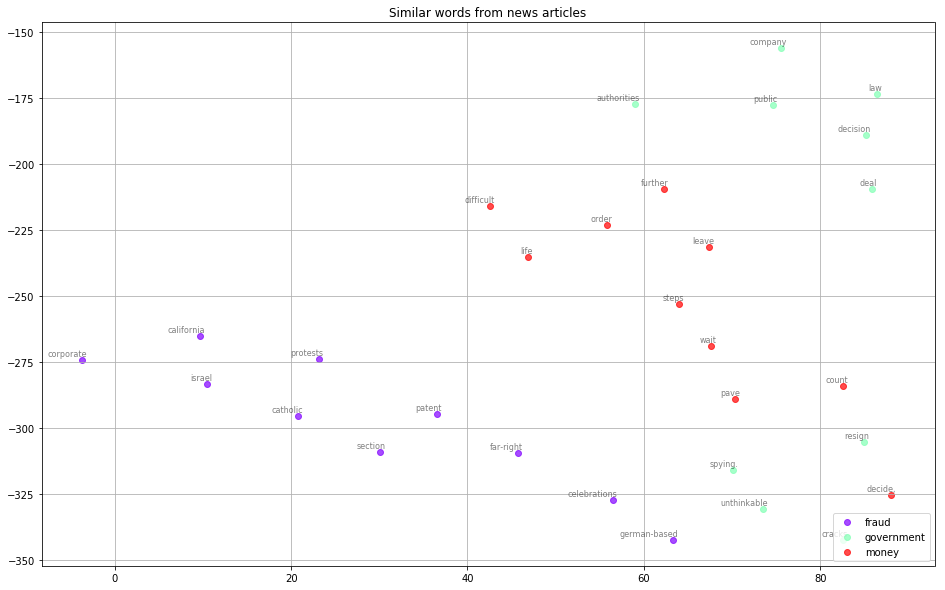

In [59]:
tsne_plot_similar_words(keywords, embeddings_2d, word_clusters, 0.7)

In [84]:
list_words = []
list_embeddings = []

for word in list(model.wv.vocab):
    list_embeddings.append(model.wv[word])
    list_words.append(word)
    
tsne_2d = TSNE(perplexity=50, n_components=2, init='pca', n_iter=500, random_state=5, verbose=1)

embeddings_2d = tsne_2d.fit_transform(list_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9289 samples in 0.026s...
[t-SNE] Computed neighbors for 9289 samples in 5.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9289
[t-SNE] Computed conditional probabilities for sample 2000 / 9289
[t-SNE] Computed conditional probabilities for sample 3000 / 9289
[t-SNE] Computed conditional probabilities for sample 4000 / 9289
[t-SNE] Computed conditional probabilities for sample 5000 / 9289
[t-SNE] Computed conditional probabilities for sample 6000 / 9289
[t-SNE] Computed conditional probabilities for sample 7000 / 9289
[t-SNE] Computed conditional probabilities for sample 8000 / 9289
[t-SNE] Computed conditional probabilities for sample 9000 / 9289
[t-SNE] Computed conditional probabilities for sample 9289 / 9289
[t-SNE] Mean sigma: 0.023551
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.499298
[t-SNE] KL divergence after 500 iterations: 1.456856


In [92]:
def tsne_plot_2d(embeddings, words=[], a=1):
    plt.figure(figsize=(14, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label='News Articles TSNE')
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc='best')
    plt.grid(True)
    # plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

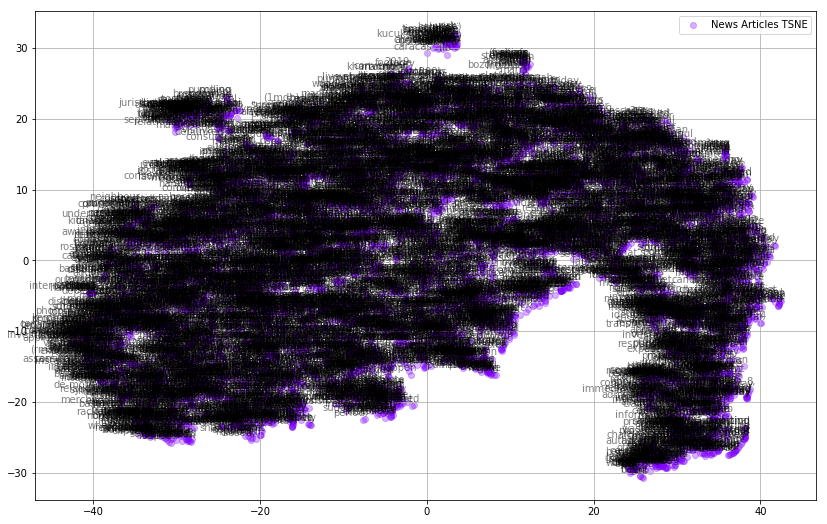

In [93]:
tsne_plot_2d(embeddings=embeddings_2d, words=list_words ,a=0.3)

In [94]:
# TODO plot only specific words ?